In [ ]:
#import libraries

In [7]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --------- ------------------------------ 2.1/8.9 MB 11.8 MB/s eta 0:00:01
   ----------------------- ---------------- 5.2/8.9 MB 13.9 MB/s eta 0:00:01
   ------------------------------------ --- 8.1/8.9 MB 14.0 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 13.8 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -

In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install boxsdk
pip install boxsdk --quiet


   ---------------------------------------- 0/2 [requests-toolbelt]
   ---------------------------------------- 0/2 [requests-toolbelt]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   ---------------------------------------- 2/2 [boxsdk]

Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pathlib
import re
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization

from sklearn.model_selection import train_test_split



In [ ]:
#helper functions

In [23]:
rng = np.random.default_rng(0)
#memory efficient singlel sample loading
def load_sample(cls: int, idx: int) -> pd.DataFrame:
    row = manifest.query("class == @cls and sample == @idx")
    if row.empty:
        raise FileNotFoundError(f"No file for class {cls}, sample {idx}")
    return pd.read_csv(row.iloc[0]["path"])
def load_iq_csv(path: str) -> np.ndarray:
    """
    Load CSV with no header, return (T,2) float32 with [I, Q].
    Assumes first column = I, second column = Q.
    """
    df = pd.read_csv(path, header=None)  # no header row
    x = df.iloc[:, :2].to_numpy(dtype=np.float32)  # take first 2 columns
    # normalize per sample
    x = x - x.mean(axis=0, keepdims=True)
    x = x / (x.std(axis=0, keepdims=True) + 1e-8)
    return x
    
def df_to_ds(df: pd.DataFrame, batch=32, shuffle=True): #datafram to dataset
    paths  = df["path"].tolist()
    labels = df["label"].tolist()

    def _py_load(path, label):
        x = load_iq_csv(path.numpy().decode())
        # add channel axis: (T,2) -> (T,2,1)
        x = np.expand_dims(x, -1).astype(np.float32)
        return x, np.int32(label)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: tf.py_function(_py_load, inp=[p, y], Tout=(tf.float32, tf.int32)),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(batch, padded_shapes=([None,2,1], []))  # variable T supported
    return ds.prefetch(tf.data.AUTOTUNE)
def plot_class_overlays(manifest: pd.DataFrame, cls: int, n=5, decim=1, normalize=True):
    """
    Overlay I & Q waveforms and a constellation for `n` random samples of a single class.
    decim: plot every decim-th point to reduce clutter.
    """
    rows = manifest[manifest["class"] == cls]
    if rows.empty:
        raise ValueError(f"No files for class {cls}")
    pick = rows.sample(min(n, len(rows)), random_state=0)

    plt.figure(); plt.title(f"I waveforms — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])  # (T,2)
        x = sig[::decim, 0]
        if normalize: x = (x - x.mean()) / (x.std() + 1e-8)
        plt.plot(x, alpha=0.7)

    plt.figure(); plt.title(f"Q waveforms — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])
        x = sig[::decim, 1]
        if normalize: x = (x - x.mean()) / (x.std() + 1e-8)
        plt.plot(x, alpha=0.7)

    plt.figure(); plt.title(f"Constellation — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])
        I, Q = sig[::decim, 0], sig[::decim, 1]
        if normalize:
            I = (I - I.mean()) / (I.std() + 1e-8)
            Q = (Q - Q.mean()) / (Q.std() + 1e-8)
        plt.plot(I, Q, ".", ms=2, alpha=0.5)
    plt.axis("equal")
    plt.show()


def plot_constellation_across_classes(manifest: pd.DataFrame, classes, per_class=3, decim=2, normalize=True):
    """
    One constellation plot comparing multiple classes.
    `per_class`: number of samples per class to plot.
    """
    plt.figure()
    for cls in classes:
        rows = manifest[manifest["class"] == cls]
        if rows.empty:
            continue
        pick = rows.sample(min(per_class, len(rows)), random_state=0)
        I_all, Q_all = [], []
        for _, r in pick.iterrows():
            sig = load_iq_csv(r["path"])
            I, Q = sig[::decim, 0], sig[::decim, 1]
            if normalize:
                I = (I - I.mean()) / (I.std() + 1e-8)
                Q = (Q - Q.mean()) / (Q.std() + 1e-8)
            I_all.append(I); Q_all.append(Q)
        if I_all:
            I_cat = np.concatenate(I_all); Q_cat = np.concatenate(Q_all)
            plt.plot(I_cat, Q_cat, ".", ms=2, alpha=0.4, label=f"class {cls}")
    plt.axis("equal"); plt.legend(); plt.title("Constellation comparison across classes")
    plt.show()

In [13]:
arr = load_iq_csv("IQ data/class1_sample1.csv")
print(arr.shape)   # (N, 2)
print(arr[:5])     # first 5 rows of [I, Q]


(1000, 2)
[[1.5394367  0.58090883]
 [1.3461232  0.7993284 ]
 [0.6722375  0.02775435]
 [1.3802036  0.9260607 ]
 [1.5444927  0.451258  ]]


In [ ]:
#data sorting

In [2]:
data_dir = Path("IQ data")
pat = re.compile(r"class(?P<cls>\d+)_sample(?P<idx>\d+)\.csv$", re.I)

rows = []
for p in data_dir.rglob("*.csv"):
    m = pat.search(p.name)
    if not m:
        continue
    rows.append({
        "class": int(m["cls"]),
        "sample": int(m["idx"]),
        "filename": p.name,
        "path": p.resolve().as_posix()
    })

# ---- Manifest (one row per file) ----
manifest = pd.DataFrame(rows).sort_values(["class", "sample"]).reset_index(drop=True)
print(f"Indexed {len(manifest)} CSVs across {manifest['class'].nunique()} classes.")
display_cols = ["class","sample","filename"]
print(manifest[display_cols].head(10))  # quick peek


Indexed 15740 CSVs across 144 classes.
   class  sample             filename
0      1       1   class1_sample1.csv
1      1       2   class1_sample2.csv
2      1       3   class1_sample3.csv
3      1       4   class1_sample4.csv
4      1       5   class1_sample5.csv
5      1       6   class1_sample6.csv
6      1       7   class1_sample7.csv
7      1       8   class1_sample8.csv
8      1       9   class1_sample9.csv
9      1      10  class1_sample10.csv


In [15]:
#validate expected size of 110 samples per class
EXPECTED = 110

iq_data = manifest.groupby("class")["sample"].nunique().rename("count")
print(counts)

# classes with wrong counts
bad = counts[counts != EXPECTED]
if not bad.empty:
    print("\nClasses with missing/excess samples:")
    for cls, cnt in bad.items():
        have = set(manifest.loc[manifest["class"]==cls, "sample"])
        need = set(range(1, EXPECTED+1))
        missing = sorted(need - have)
        extras  = sorted(have - need)
        print(f"  class {cls}: {cnt}/{EXPECTED} "
              f"{'(missing: ' + str(missing[:10]) + (' ...' if len(missing)>10 else '') + ')' if missing else ''}"
              f"{'(extras: '  + str(extras[:10])  + (' ...' if len(extras)>10  else '') + ')' if extras  else ''}")

#creates dict for data
iq = {}
for (cls, idx), grp in manifest.set_index(["class","sample"]).groupby(level=[0,1]):
    iq.setdefault(cls, {})[idx] = pd.read_csv(grp["path"].iloc[0])

# example access:
# df = iq[10][104]


class
1      110
10     110
11     110
12     110
13     110
      ... 
225    110
226    110
227    110
228    110
229    110
Name: count, Length: 144, dtype: int64

Classes with missing/excess samples:
  class 22: 10/110 (missing: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12] ...)


In [ ]:
# test,train,split

In [17]:
classes = sorted(manifest["class"].unique())
cls2id = {c:i for i,c in enumerate(classes)}
manifest["label"] = manifest["class"].map(cls2id)

train_df, test_df  = train_test_split(manifest, test_size=0.15, stratify=manifest["label"], random_state=42)
train_df, val_df   = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=42)

train_ds = df_to_ds(train_df, batch=64, shuffle=True)
val_ds   = df_to_ds(val_df,   batch=64, shuffle=False)
test_ds  = df_to_ds(test_df,  batch=64, shuffle=False)
n_classes = len(classes)

In [ ]:
# ------------ Data Visualization

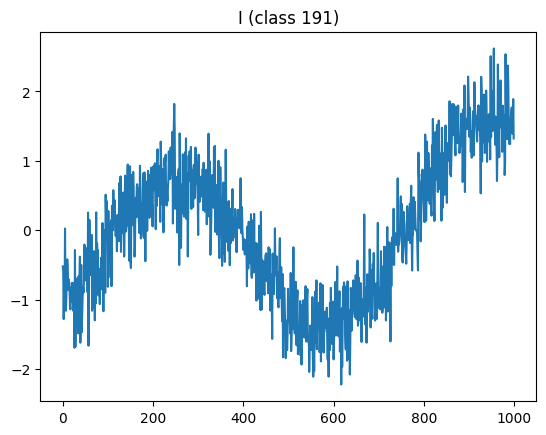

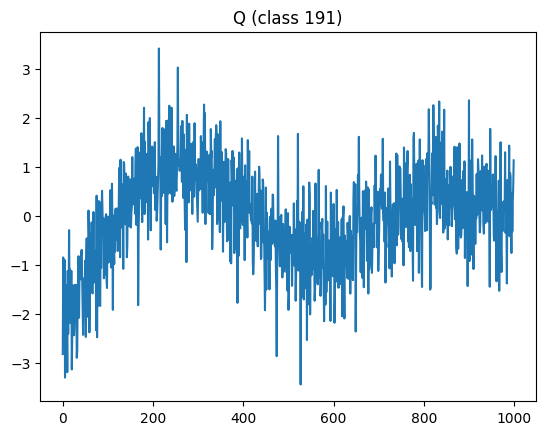

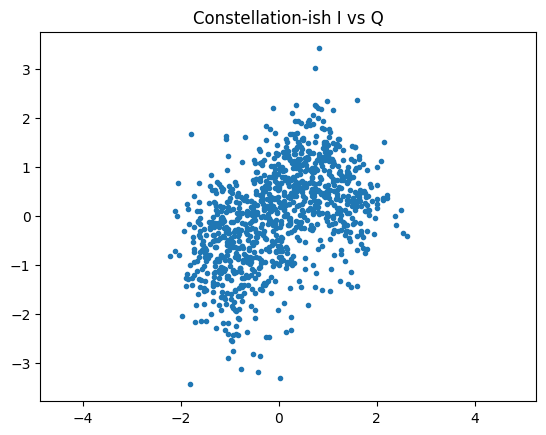

In [22]:
#visualize single .csv
row = train_df.sample(1, random_state=0).iloc[0]
sig = load_iq_csv(row["path"])  # (T,2)
plt.figure(); plt.plot(sig[:,0]); plt.title(f"I (class {row['class']})")
plt.figure(); plt.plot(sig[:,1]); plt.title(f"Q (class {row['class']})")
plt.figure(); plt.plot(sig[:,0], sig[:,1], "."); plt.title("Constellation-ish I vs Q"); plt.axis("equal")
plt.show()

In [ ]:
# -------- Visualize single class and class comparison

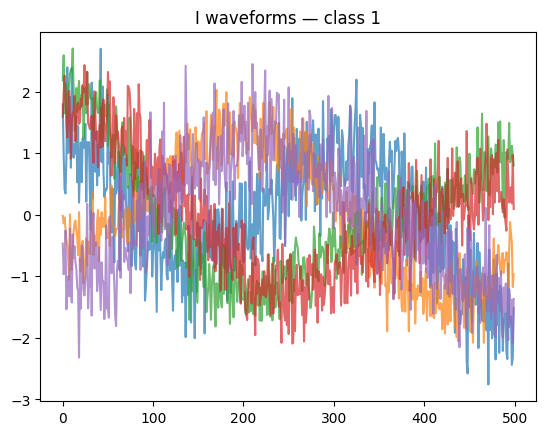

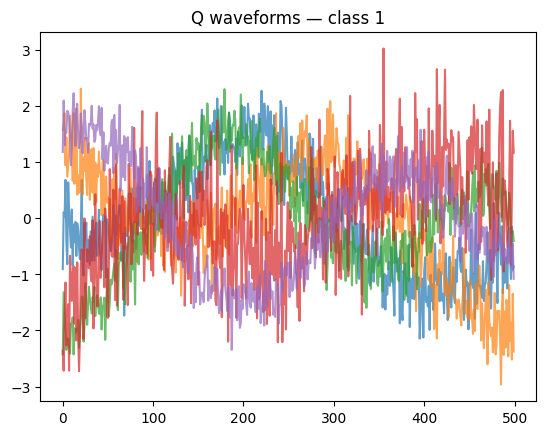

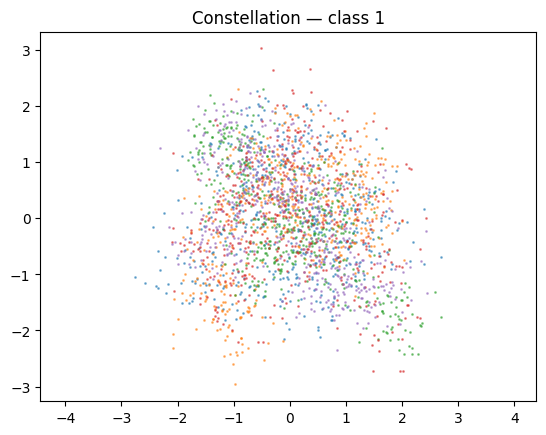

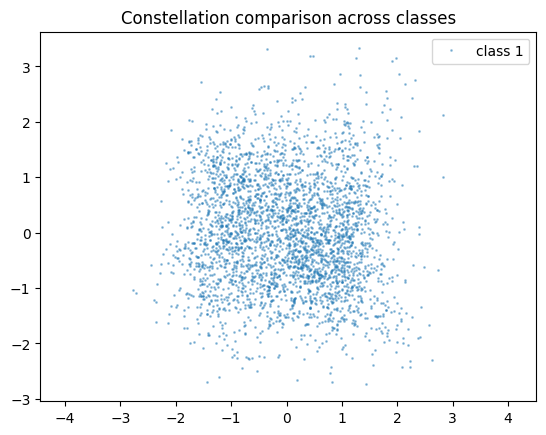

In [27]:
# Same class overlays (e.g., class 1, 6 samples)
plot_class_overlays(manifest, cls=1, n=5, decim=2)

# Compare classes 1, 5, 10 with 3 samples each
plot_constellation_across_classes(manifest, classes=[1,2,3], per_class=10, decim=3)
